# Diseño de Filtros IIR Pasabanda y Rechaza Banda por Transformada Bilineal

## Introducción a los Filtros IIR

Los filtros de Respuesta Infinita al Impulso (IIR, por sus siglas en inglés *Infinite Impulse Response*) se caracterizan porque su respuesta al impulso $h[n]$ es, teóricamente, de duración infinita. Esto se debe a la presencia de realimentación en su estructura.

**Características Principales:**
* **Eficiencia:** Los filtros IIR suelen requerir un orden (y por lo tanto, menos coeficientes y menor carga computacional) mucho menor que un filtro FIR para lograr especificaciones de respuesta en frecuencia similares, especialmente para transiciones abruptas.
* **Fase No Lineal:** Generalmente, los filtros IIR no tienen fase lineal, lo que puede ser una desventaja en aplicaciones donde la preservación de la forma de onda es crítica. Sin embargo, existen técnicas para el diseño de filtros IIR con fase aproximadamente lineal en la banda de paso o para la corrección de fase posterior.
* **Estabilidad:** A diferencia de los FIR que son inherentemente estables, la estabilidad de un filtro IIR debe ser verificada asegurándose de que todos los polos de su función de transferencia $H(z)$ se encuentren dentro del círculo unitario en el plano Z.

La ecuación en diferencias de un filtro IIR general es:
$$ \sum_{k=0}^{N} a_k y[n-k] = \sum_{k=0}^{M} b_k x[n-k] $$
Normalizando $a_0=1$:
$$ y[n] = \sum_{k=0}^{M} b_k x[n-k] - \sum_{k=1}^{N} a_k y[n-k] $$
Su función de transferencia en el dominio Z es:
$$ H(z) = \frac{Y(z)}{X(z)} = \frac{\sum_{k=0}^{M} b_k z^{-k}}{1 + \sum_{k=1}^{N} a_k z^{-k}} $$

## Método de Diseño por Transformada Bilineal

El diseño de filtros IIR a menudo se basa en el diseño de prototipos de filtros analógicos (Butterworth, Chebyshev, Elíptico) debido a que sus teorías de diseño están muy bien establecidas. La **transformada bilineal** es un método común para convertir la función de transferencia de un filtro analógico $H_a(s)$ a una función de transferencia de un filtro digital $H(z)$.

La transformación es:
$$ s = \frac{2}{T_s} \frac{1-z^{-1}}{1+z^{-1}} = \frac{2}{T_s} \frac{z-1}{z+1} $$
Donde $T_s$ es el periodo de muestreo ($T_s = 1/f_s$).

### Warping de Frecuencia (Pre-distorsión)
La transformada bilineal mapea todo el eje $j\Omega$ del plano $s$ al círculo unitario $e^{j\omega}$ del plano $z$, pero esta relación no es lineal. Esto se conoce como **warping de frecuencia**:
$$ \omega = 2 \arctan\left(\frac{\Omega T_s}{2}\right) \quad \text{o bien} \quad \Omega = \frac{2}{T_s} \tan\left(\frac{\omega T_s}{2}\right) $$
Donde $\omega$ es la frecuencia digital (radianes/muestra) y $\Omega$ es la frecuencia analógica (radianes/segundo).
Para asegurar que el filtro digital tenga las frecuencias críticas (ej. de corte, de banda de paso/rechazo) en las ubicaciones correctas, estas frecuencias digitales deseadas deben ser "pre-warped" a sus correspondientes frecuencias analógicas antes de diseñar el filtro analógico prototipo.

### Transformaciones de Frecuencia Analógicas
Para diseñar filtros pasabanda o rechaza banda, a menudo se parte de un prototipo analógico pasabajos normalizado $H_{LP}(s')$ (con $\Omega_c=1 \text{ rad/s}$). Luego se aplican transformaciones de frecuencia en el dominio analógico:

1.  **De Pasabajos a Pasabanda (BPF):**
    Se reemplaza $s'$ en $H_{LP}(s')$ por:
    $$ s' \rightarrow \frac{s^2 + \Omega_0^2}{s \cdot BW} $$
    Donde:
    * $\Omega_0 = \sqrt{\Omega_{c1} \Omega_{c2}}$ es la frecuencia central geométrica (pre-warped).
    * $BW = \Omega_{c2} - \Omega_{c1}$ es el ancho de banda (pre-warped).
    * $\Omega_{c1}$ y $\Omega_{c2}$ son las frecuencias de corte inferior y superior de la banda de paso analógica (pre-warped).

2.  **De Pasabajos a Rechaza Banda (BSF o Notch):**
    Se reemplaza $s'$ en $H_{LP}(s')$ por:
    $$ s' \rightarrow \frac{s \cdot BW}{s^2 + \Omega_0^2} $$
    Donde $\Omega_0$ y $BW$ se definen de manera similar, pero referidos a las frecuencias de la banda de rechazo.

Afortunadamente, `scipy.signal` maneja la mayoría de estos pasos (pre-warping, transformaciones de frecuencia, y transformada bilineal) internamente cuando se especifican los parámetros adecuados.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Configuración general para los gráficos
plt.rcParams['figure.figsize'] = [25, 4] # Tamaño de figura por defecto
plt.rcParams['figure.dpi'] = 90         # Resolución de figura por defecto

# --- Funciones para graficar en el Dominio del Tiempo ---

def plot_signal_time_domain(t, signal_data, title="Señal en el Dominio del Tiempo", xlabel="Tiempo (s)", ylabel="Amplitud"):
    """Grafica una señal (amplitud vs. tiempo) dado un vector de tiempo 't'."""
    plt.figure()
    plt.plot(t, signal_data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

def plot_impulse_response(h_coeffs, title="Respuesta al Impulso h[n]", xlabel="Muestras (n)", ylabel="Amplitud"):
    """Grafica una respuesta al impulso (h[n] vs. n), usando un stem plot."""
    plt.figure()
    try:
        markerline, stemlines, baseline = plt.stem(np.arange(len(h_coeffs)), h_coeffs, basefmt=" ", use_line_collection=True)
        plt.setp(markerline, markersize=4)
    except TypeError: 
        plt.stem(np.arange(len(h_coeffs)), h_coeffs, basefmt=" ")
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', lw=0.5) 
    plt.show()

# --- Funciones para graficar en el Dominio de la Frecuencia ---

def plot_freq_response(w_freq_axis, h_complex_response, title="Respuesta en Frecuencia del Filtro", fs=None):
    """
    Grafica la respuesta de magnitud (dB) y fase de un FILTRO.
    w_freq_axis: eje de frecuencias.
    h_complex_response: respuesta compleja del filtro (salida de signal.freqz).
    fs: frecuencia de muestreo (opcional, para interpretar y etiquetar el eje en Hz).
    """
    fig, axs = plt.subplots(2, 1, figsize=(10,6))
    
    magnitude_db = 20 * np.log10(np.abs(h_complex_response) + 1e-9) 

    freq_axis_label = 'Frecuencia (Hz)' if fs else 'Frecuencia Normalizada'
    w_freq_axis_plot = w_freq_axis 

    if not fs: 
        if np.max(w_freq_axis) <= (np.pi + 1e-3) and np.min(w_freq_axis) >= 0 : 
             freq_axis_label = 'Frecuencia Normalizada (x $\pi$ rad/muestra)'
             w_freq_axis_plot = w_freq_axis / np.pi
        elif np.max(w_freq_axis) <= (0.5 + 1e-3) and np.min(w_freq_axis) >= 0: 
             freq_axis_label = 'Frecuencia Normalizada (ciclos/muestra)'

    axs[0].plot(w_freq_axis_plot, magnitude_db)
    axs[0].set_title(f'{title} - Magnitud')
    axs[0].set_xlabel(freq_axis_label)
    axs[0].set_ylabel('Magnitud (dB)')
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].set_ylim([-120, max(np.max(magnitude_db) + 10, 10)]) 

    phase = np.unwrap(np.angle(h_complex_response))
    axs[1].plot(w_freq_axis_plot, phase)
    axs[1].set_title(f'{title} - Fase (desenvuelta)')
    axs[1].set_xlabel(freq_axis_label)
    axs[1].set_ylabel('Fase (radianes)')
    axs[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_dft_spectrum(freq_axis_hz, dft_coeffs_complex, title="Espectro de la DFT (Señal)", shift_spectrum=True):
    """
    Grafica el espectro de magnitud y fase de la DFT de una SEÑAL.
    freq_axis_hz: Eje de frecuencias en Hz.
    dft_coeffs_complex: Coeficientes de la DFT.
    """
    dft_coeffs_to_plot = dft_coeffs_complex
    freq_axis_to_plot_hz = freq_axis_hz

    if shift_spectrum:
        dft_coeffs_to_plot = np.fft.fftshift(dft_coeffs_complex)
        freq_axis_to_plot_hz = np.fft.fftshift(freq_axis_hz)

    magnitude_spectrum = np.abs(dft_coeffs_to_plot)
    phase_spectrum = np.angle(dft_coeffs_to_plot)
    unwrapped_phase_spectrum = np.unwrap(phase_spectrum)

    fig, axs = plt.subplots(2, 1, figsize=(10,6))

    axs[0].plot(freq_axis_to_plot_hz, magnitude_spectrum)
    axs[0].set_title(f'{title} - Magnitud')
    axs[0].set_xlabel('Frecuencia (Hz)')
    axs[0].set_ylabel('|X(k)| (Magnitud DFT)')
    axs[0].grid(True, linestyle='--', alpha=0.7)
    if shift_spectrum and len(freq_axis_to_plot_hz) > 0:
      axs[0].set_xlim([np.min(freq_axis_to_plot_hz), np.max(freq_axis_to_plot_hz)])

    axs[1].plot(freq_axis_to_plot_hz, unwrapped_phase_spectrum)
    axs[1].set_title(f'{title} - Fase (desenvuelta)')
    axs[1].set_xlabel('Frecuencia (Hz)')
    axs[1].set_ylabel('Fase (radianes)')
    axs[1].grid(True, linestyle='--', alpha=0.7)
    if shift_spectrum and len(freq_axis_to_plot_hz) > 0:
      axs[1].set_xlim([np.min(freq_axis_to_plot_hz), np.max(freq_axis_to_plot_hz)])

    plt.tight_layout()
    plt.show()

def plot_zplane(b, a, title="Diagrama de Polos y Ceros del Filtro Digital"):
    """Grafica el diagrama de polos y ceros de un filtro H(z)=b/a."""
    poles = np.roots(a)
    zeros = np.roots(b)

    plt.figure(figsize=(6,6))
    # Dibujar el círculo unitario
    uc = plt.Circle((0,0), radius=1, fill=False, color='grey', ls='--', alpha=0.7)
    plt.gca().add_patch(uc)

    plt.plot(np.real(zeros), np.imag(zeros), 'o', markersize=8, label='Ceros', mfc='none', c='blue')
    plt.plot(np.real(poles), np.imag(poles), 'x', markersize=8, label='Polos', c='red')

    plt.title(title)
    plt.xlabel('Parte Real (Re)')
    plt.ylabel('Parte Imaginaria (Im)')
    plt.axis('equal') 
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

<>:55: SyntaxWarning: invalid escape sequence '\p'
<>:55: SyntaxWarning: invalid escape sequence '\p'
C:\Users\maxim\AppData\Local\Temp\ipykernel_27732\2012726337.py:55: SyntaxWarning: invalid escape sequence '\p'
  freq_axis_label = 'Frecuencia Normalizada (x $\pi$ rad/muestra)'


## Diseño de Filtro IIR Pasabanda

Diseñaremos un filtro IIR pasabanda utilizando un prototipo analógico Butterworth. La función `scipy.signal.butter` (o la más general `scipy.signal.iirfilter`) puede realizar el diseño directamente especificando `btype='bandpass'` y `analog=False`, manejando internamente el pre-warping y la transformada bilineal.

**Especificaciones:**
* Tipo de filtro: Butterworth.
* Frecuencia de muestreo ($f_s$).
* Frecuencias de corte de la banda de paso ($f_{p1}, f_{p2}$).
* Orden del filtro ($N$).

Diseñando Filtro IIR Pasabanda (Butterworth Orden 4):
  Fs = 2000.0 Hz
  Banda de paso: [200.0 Hz, 500.0 Hz]

Coeficientes del filtro (numerador b): [ 0.018563  0.       -0.074252  0.        0.111378  0.       -0.074252
  0.        0.018563]
Coeficientes del filtro (denominador a): [ 1.       -2.83826   4.682369 -5.254272  4.497681 -2.818125  1.311542
 -0.402113  0.076197]


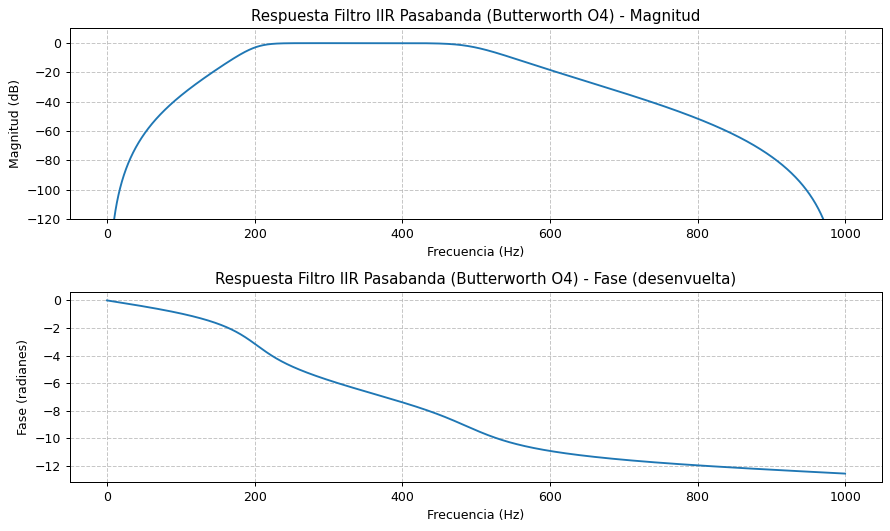

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


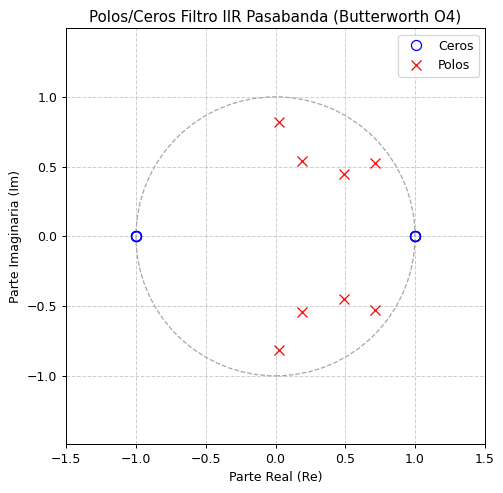

In [10]:
# Especificaciones del filtro digital pasabanda
fs_bp = 2000.0      # Frecuencia de muestreo (Hz)
# nyq_freq_bp = fs_bp / 2.0 # No es estrictamente necesario aquí si fs se pasa a la función
lowcut_bp_डिज = 200.0  # Frecuencia de corte inferior de la banda de paso (Hz)
highcut_bp_डिज = 500.0 # Frecuencia de corte superior de la banda de paso (Hz)
order_bp = 4          # Orden del filtro Butterworth

print(f"Diseñando Filtro IIR Pasabanda (Butterworth Orden {order_bp}):")
print(f"  Fs = {fs_bp} Hz")
print(f"  Banda de paso: [{lowcut_bp_डिज} Hz, {highcut_bp_डिज} Hz]")

# Diseñar directamente usando signal.butter
# Wn: Para pasabanda o rechaza banda, secuencia de 2 elementos con frecuencias críticas.
# fs: Frecuencia de muestreo del sistema digital.
b_bp, a_bp = signal.butter(N=order_bp,
                           Wn=[lowcut_bp_डिज, highcut_bp_डिज],
                           btype='bandpass',
                           analog=False,
                           output='ba', # Coeficientes del numerador (b) y denominador (a)
                           fs=fs_bp)

print(f"\nCoeficientes del filtro (numerador b): {np.round(b_bp, 6)}")
print(f"Coeficientes del filtro (denominador a): {np.round(a_bp, 6)}")

# Analizar la respuesta en frecuencia
w_hz_bp, h_complex_bp = signal.freqz(b_bp, a_bp, worN=8000, fs=fs_bp)
plot_freq_response(w_hz_bp, h_complex_bp, 
                   title=f"Respuesta Filtro IIR Pasabanda (Butterworth O{order_bp})", 
                   fs=fs_bp)

# Diagrama de polos y ceros
plot_zplane(b_bp, a_bp, title=f"Polos/Ceros Filtro IIR Pasabanda (Butterworth O{order_bp})")

## Diseño de Filtro IIR Rechaza Banda (Notch)

Similar al pasabanda, diseñaremos un filtro IIR rechaza banda (o notch). Utilizaremos un prototipo Chebyshev Tipo I para ilustrar el uso de otro tipo de filtro.

**Especificaciones:**
* Tipo de filtro: Chebyshev Tipo I.
* Frecuencia de muestreo ($f_s$).
* Frecuencias de corte de la banda de rechazo ($f_{s1}, f_{s2}$).
* Orden del filtro ($N$).
* Rizado máximo en la banda de paso (`rp` en dB).

Diseñando Filtro IIR Rechaza Banda (Chebyshev I Orden 4, rp=0.5dB):
  Fs = 2000.0 Hz
  Banda de rechazo: [300.0 Hz, 400.0 Hz]

Coeficientes del filtro (numerador b): [ 0.6066   -2.230588  5.502267 -8.576858 10.224574 -8.576858  5.502267
 -2.230588  0.6066  ]
Coeficientes del filtro (denominador a): [ 1.       -3.263702  7.118258 -9.901792 10.567406 -7.999882  4.6532
 -1.730277  0.433235]


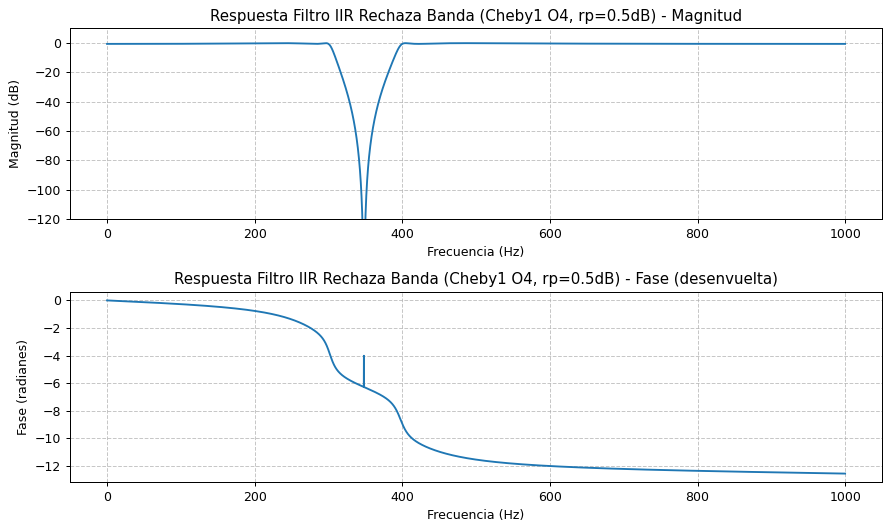

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


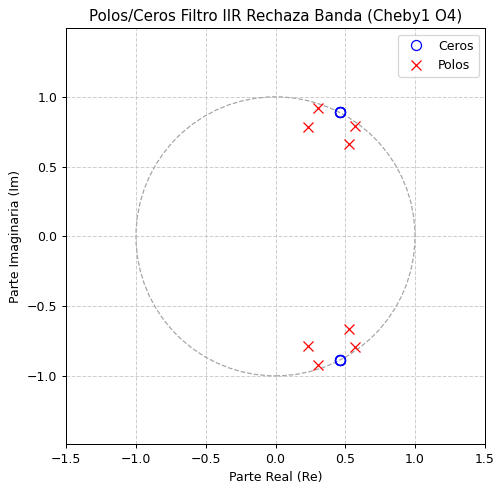

In [11]:
# Especificaciones del filtro digital rechaza banda
fs_bs = 2000.0       # Frecuencia de muestreo (Hz)
lowstop_bs_डिज = 300.0  # Frecuencia inferior de la banda de rechazo (Hz)
highstop_bs_डिज = 400.0 # Frecuencia superior de la banda de rechazo (Hz)
order_bs = 4         # Orden del filtro
rp_bs = 0.5          # Rizado máximo en la banda de paso (dB) para Chebyshev I

print(f"Diseñando Filtro IIR Rechaza Banda (Chebyshev I Orden {order_bs}, rp={rp_bs}dB):")
print(f"  Fs = {fs_bs} Hz")
print(f"  Banda de rechazo: [{lowstop_bs_डिज} Hz, {highstop_bs_डिज} Hz]")

# Diseñar directamente usando signal.cheby1
b_bs, a_bs = signal.cheby1(N=order_bs,
                           rp=rp_bs,
                           Wn=[lowstop_bs_डिज, highstop_bs_डिज],
                           btype='bandstop',
                           analog=False,
                           output='ba',
                           fs=fs_bs)

print(f"\nCoeficientes del filtro (numerador b): {np.round(b_bs, 6)}")
print(f"Coeficientes del filtro (denominador a): {np.round(a_bs, 6)}")

# Analizar la respuesta en frecuencia
w_hz_bs, h_complex_bs = signal.freqz(b_bs, a_bs, worN=8000, fs=fs_bs)
plot_freq_response(w_hz_bs, h_complex_bs, 
                   title=f"Respuesta Filtro IIR Rechaza Banda (Cheby1 O{order_bs}, rp={rp_bs}dB)", 
                   fs=fs_bs)

# Diagrama de polos y ceros
plot_zplane(b_bs, a_bs, title=f"Polos/Ceros Filtro IIR Rechaza Banda (Cheby1 O{order_bs})")

--- Aplicando Filtro Pasabanda ---


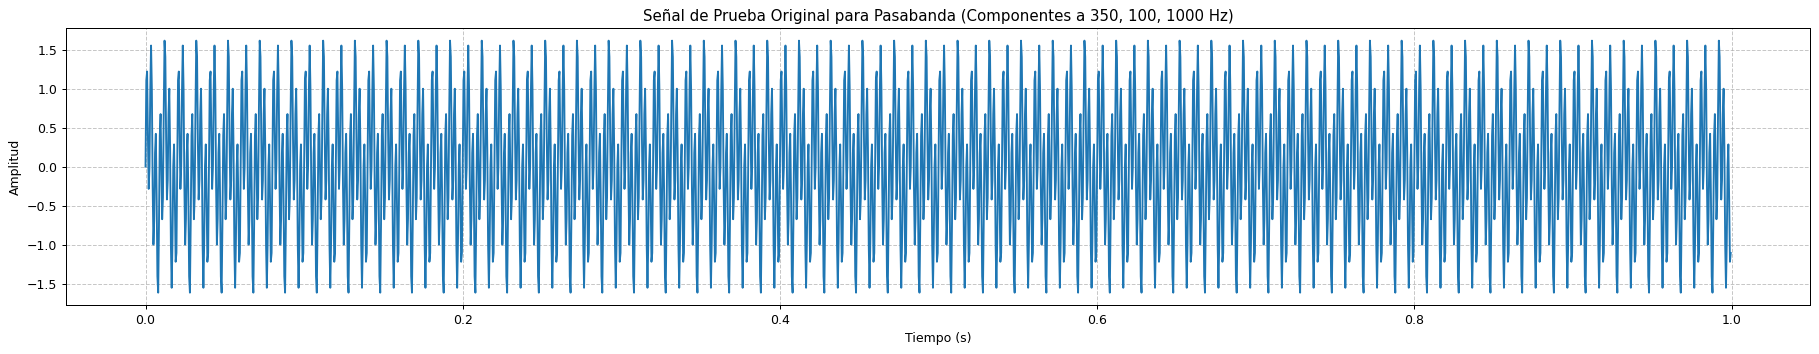

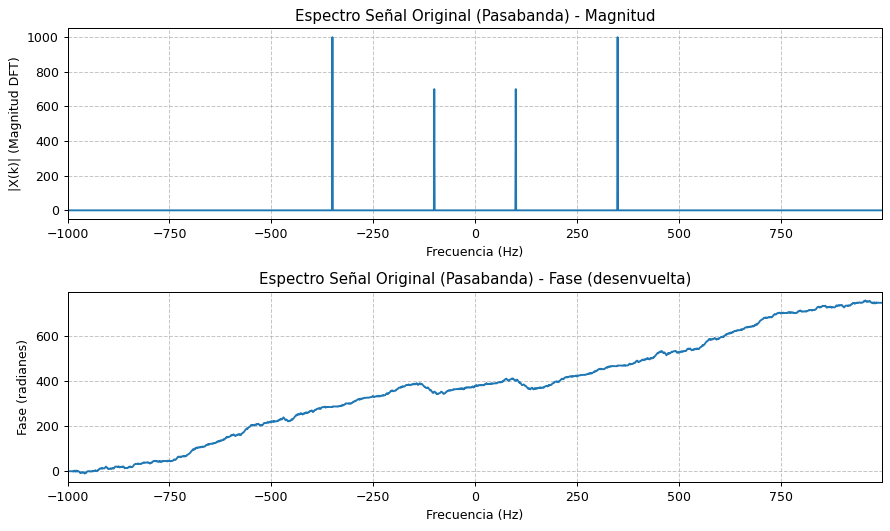

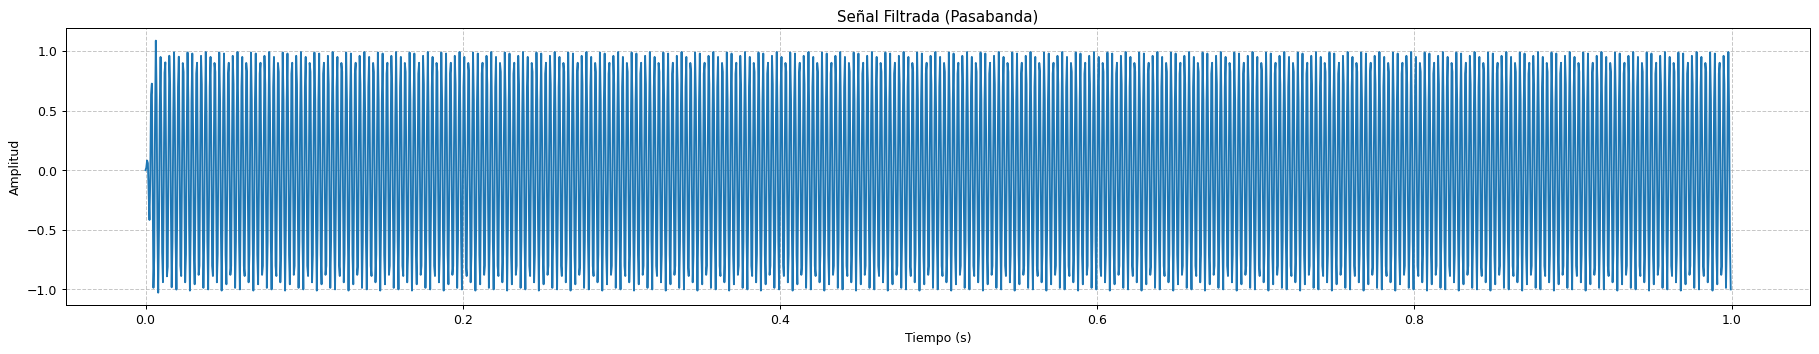

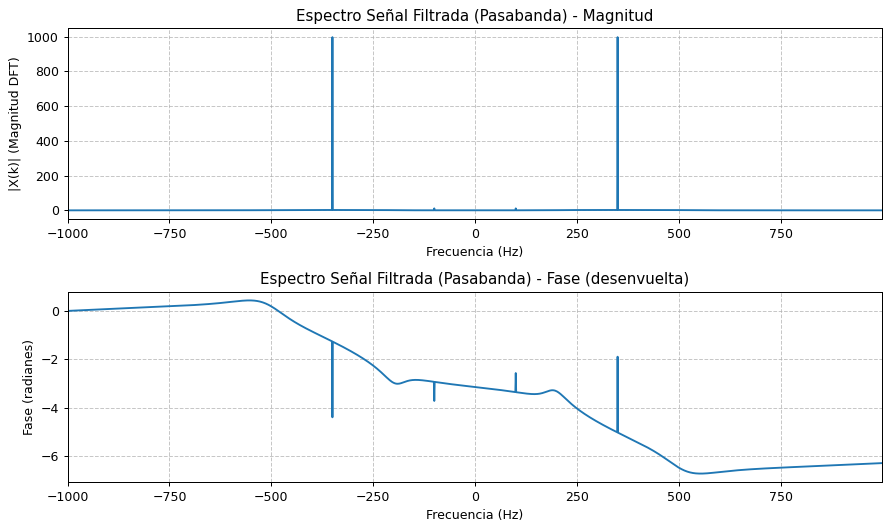


--- Aplicando Filtro Rechaza Banda ---


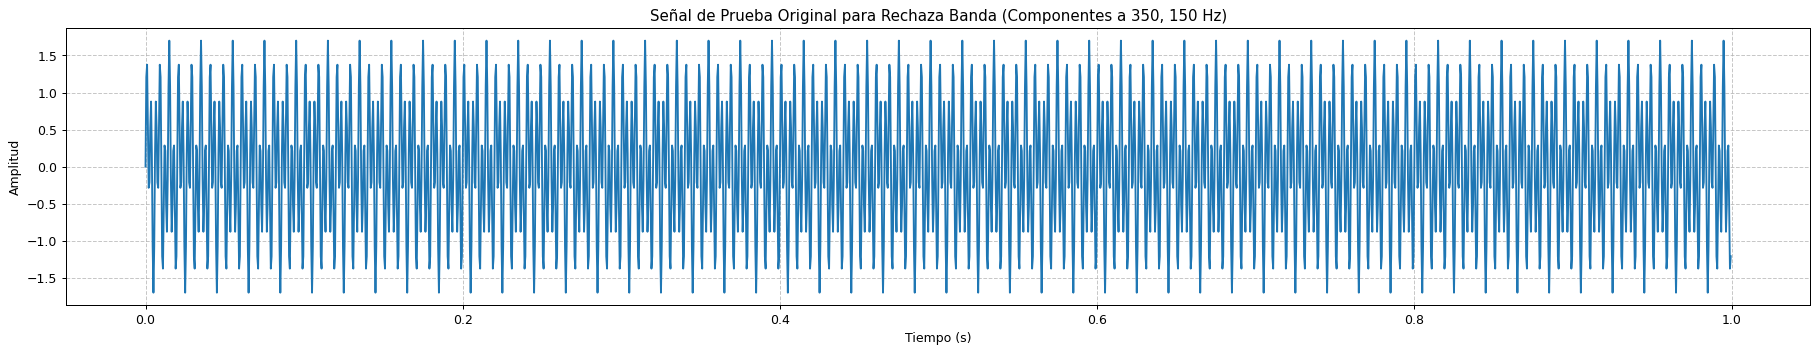

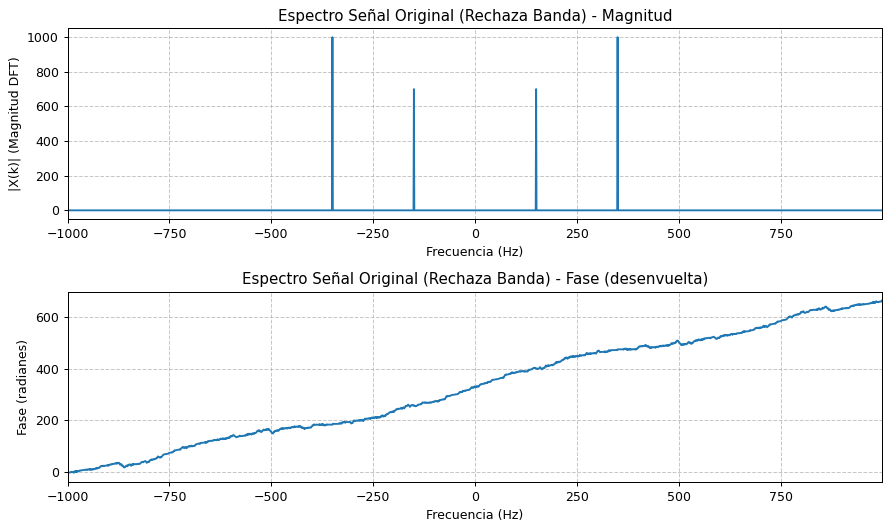

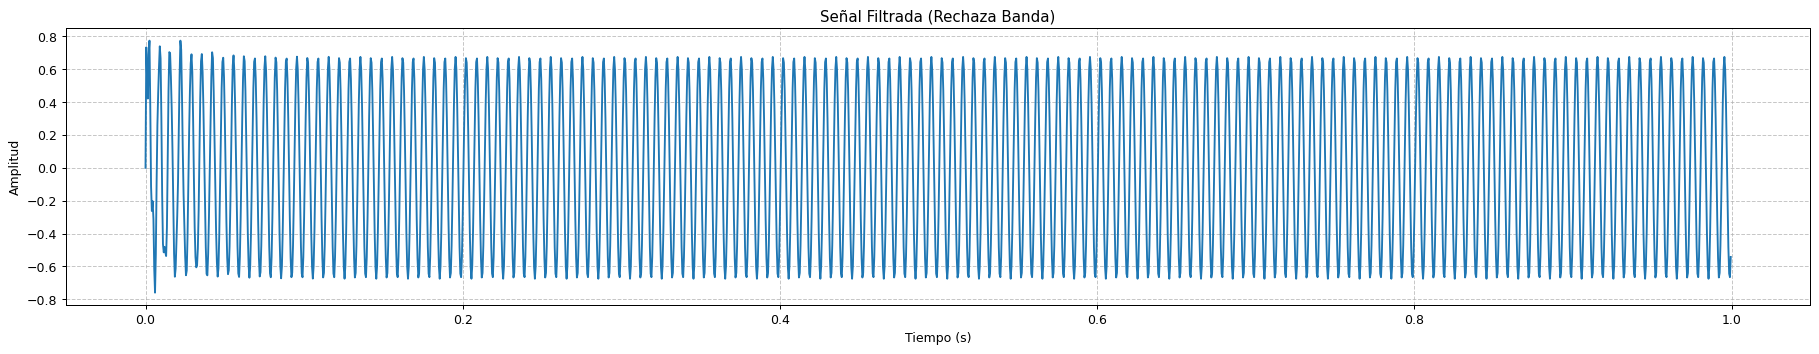

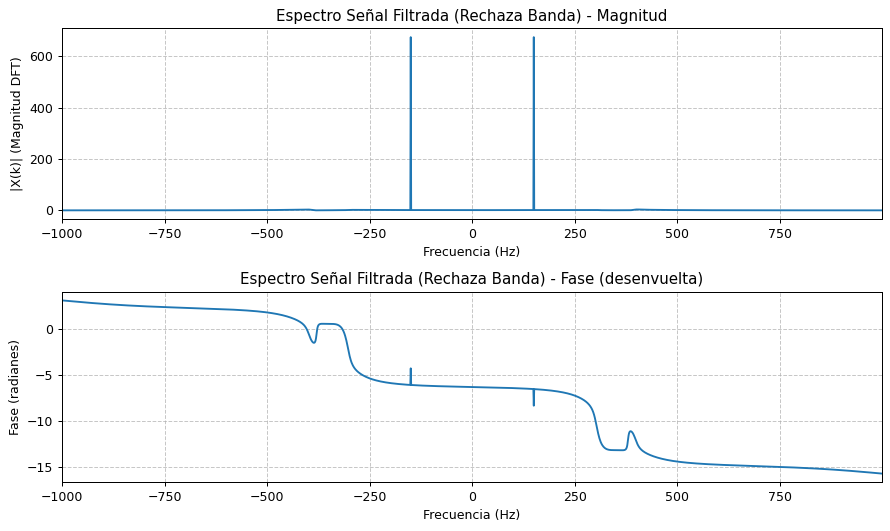

In [12]:
# Aplicación del Filtro Pasabanda
fs = fs_bp # Usar la misma fs que para el diseño del pasabanda
t_test_bp = np.arange(0, 1.0, 1/fs) # 1 segundo de señal

# Componentes de la señal: uno dentro de la banda de paso, uno fuera
f_in_band_bp = (lowcut_bp_डिज + highcut_bp_डिज) / 2 # Frecuencia central de la banda de paso
f_out_band_bp1 = lowcut_bp_डिज / 2 
f_out_band_bp2 = highcut_bp_डिज * 2

sig_in_bp = 1.0 * np.sin(2 * np.pi * f_in_band_bp * t_test_bp)
sig_out_bp1 = 0.7 * np.sin(2 * np.pi * f_out_band_bp1 * t_test_bp)
sig_out_bp2 = 0.7 * np.sin(2 * np.pi * f_out_band_bp2 * t_test_bp)
test_signal_bp = sig_in_bp + sig_out_bp1 + sig_out_bp2

print("--- Aplicando Filtro Pasabanda ---")
plot_signal_time_domain(t_test_bp, test_signal_bp, title=f"Señal de Prueba Original para Pasabanda (Componentes a {f_in_band_bp:.0f}, {f_out_band_bp1:.0f}, {f_out_band_bp2:.0f} Hz)")

# Espectro de la señal original
N_bp_test = len(test_signal_bp)
dft_coeffs_bp_orig = np.fft.fft(test_signal_bp)
freq_axis_bp_hz = np.fft.fftfreq(N_bp_test, d=1/fs)
plot_dft_spectrum(freq_axis_bp_hz, dft_coeffs_bp_orig, title="Espectro Señal Original (Pasabanda)")


filtered_signal_bp = signal.lfilter(b_bp, a_bp, test_signal_bp)
plot_signal_time_domain(t_test_bp, filtered_signal_bp, title="Señal Filtrada (Pasabanda)")

# Espectro de la señal filtrada
dft_coeffs_bp_filt = np.fft.fft(filtered_signal_bp)
plot_dft_spectrum(freq_axis_bp_hz, dft_coeffs_bp_filt, title="Espectro Señal Filtrada (Pasabanda)")


# Aplicación del Filtro Rechaza Banda
fs = fs_bs # Usar la misma fs que para el diseño del rechaza banda
t_test_bs = np.arange(0, 1.0, 1/fs) # 1 segundo de señal

# Componentes de la señal: uno dentro de la banda de rechazo, uno fuera
f_in_stopband_bs = (lowstop_bs_डिज + highstop_bs_डिज) / 2 # Frecuencia central de la banda de rechazo
f_out_stopband_bs = lowstop_bs_डिज / 2 

sig_in_bs = 1.0 * np.sin(2 * np.pi * f_in_stopband_bs * t_test_bs)
sig_out_bs = 0.7 * np.sin(2 * np.pi * f_out_stopband_bs * t_test_bs)
test_signal_bs = sig_in_bs + sig_out_bs

print("\n--- Aplicando Filtro Rechaza Banda ---")
plot_signal_time_domain(t_test_bs, test_signal_bs, title=f"Señal de Prueba Original para Rechaza Banda (Componentes a {f_in_stopband_bs:.0f}, {f_out_stopband_bs:.0f} Hz)")

# Espectro de la señal original
N_bs_test = len(test_signal_bs)
dft_coeffs_bs_orig = np.fft.fft(test_signal_bs)
freq_axis_bs_hz = np.fft.fftfreq(N_bs_test, d=1/fs)
plot_dft_spectrum(freq_axis_bs_hz, dft_coeffs_bs_orig, title="Espectro Señal Original (Rechaza Banda)")

filtered_signal_bs = signal.lfilter(b_bs, a_bs, test_signal_bs)
plot_signal_time_domain(t_test_bs, filtered_signal_bs, title="Señal Filtrada (Rechaza Banda)")

# Espectro de la señal filtrada
dft_coeffs_bs_filt = np.fft.fft(filtered_signal_bs)
plot_dft_spectrum(freq_axis_bs_hz, dft_coeffs_bs_filt, title="Espectro Señal Filtrada (Rechaza Banda)")